<a href="https://colab.research.google.com/github/Untick/Selector_ObjDet/blob/Trokhachev-Anton-folder/Trokhachev%20Anton/%D0%A2%D1%80%D0%BE%D1%85%D0%B0%D1%87%D0%B5%D0%B2_%D0%90%D0%BD%D1%82%D0%BE%D0%BD_DeepImageSearch_on_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install DeepImageSearch
from DeepImageSearch import Load_Data,Search_Setup

import DeepImageSearch.config as config
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import numpy as np
from torchvision import transforms
import torch
from torch.autograd import Variable
import timm
from PIL import ImageOps
import math
import faiss
import gdown

class Load_Data:
    """A class for loading data from single/multiple folders or a CSV file"""

    def __init__(self):
        """
        Initializes an instance of LoadData class
        """
        pass
    
    def from_folder(self, folder_list: list):
        """
        Adds images from the specified folders to the image_list.
        Parameters:
        -----------
        folder_list : list
            A list of paths to the folders containing images to be added to the image_list.
        """
        self.folder_list = folder_list
        image_path = []
        for folder in self.folder_list:
            for root, dirs, files in os.walk(folder):
                for file in files:
                    if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                        image_path.append(os.path.join(root, file))
        return image_path

    def from_csv(self, csv_file_path: str, images_column_name: str):
        """
        Adds images from the specified column of a CSV file to the image_list.
        Parameters:
        -----------
        csv_file_path : str
            The path to the CSV file.
        images_column_name : str
            The name of the column containing the paths to the images to be added to the image_list.
        """
        self.csv_file_path = csv_file_path
        self.images_column_name = images_column_name
        return pd.read_csv(self.csv_file_path)[self.images_column_name].to_list()

class Search_Setup:
    """ A class for setting up and running image similarity search."""
    def __init__(self, image_list: list, model_name='vgg19', pretrained=True, image_count: int = None):
        """
        Parameters:
        -----------
        image_list : list
        A list of images to be indexed and searched.
        model_name : str, optional (default='vgg19')
        The name of the pre-trained model to use for feature extraction.
        pretrained : bool, optional (default=True)
        Whether to use the pre-trained weights for the chosen model.
        image_count : int, optional (default=None)
        The number of images to be indexed and searched. If None, all images in the image_list will be used.
        """
        self.model_name = model_name
        self.pretrained = pretrained
        self.image_data = pd.DataFrame()
        self.d = None
        if image_count==None:
            self.image_list = image_list
        else:
            self.image_list = image_list[:image_count]

        if f'metadata-files/{self.model_name}' not in os.listdir():
            try:
                os.makedirs(f'metadata-files/{self.model_name}')
            except Exception as e:
                pass
                #print(f'\033[91m file already exists: metadata-files/{self.model_name}')

        # Load the pre-trained model and remove the last layer
        print("\033[91m Please Wait Model Is Loading or Downloading From Server!")
        base_model = timm.create_model(self.model_name, pretrained=self.pretrained)
        self.model = torch.nn.Sequential(*list(base_model.children())[:-1])
        self.model.eval()
        print(f"\033[92m Model Loaded Successfully: {model_name}")

    def _extract(self, img):
        # Resize and convert the image
        img = img.resize((224, 224))
        img = img.convert('RGB')

        # Preprocess the image
        preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229,0.224, 0.225]),
        ])
        x = preprocess(img)
        x = Variable(torch.unsqueeze(x, dim=0).float(), requires_grad=False)

        # Extract features
        feature = self.model(x)
        feature = feature.data.numpy().flatten()
        return feature / np.linalg.norm(feature)

    def _get_feature(self, image_data: list):
        self.image_data = image_data
        features = []
        for img_path in tqdm(self.image_data):  # Iterate through images
            # Extract features from the image
            try:
                feature = self._extract(img=Image.open(img_path))
                features.append(feature)
            except:
               # If there is an error, append None to the feature list
               features.append(None)
               continue
        return features

    def _start_feature_extraction(self):
        image_data = pd.DataFrame()
        image_data['images_paths'] = self.image_list
        f_data = self._get_feature(self.image_list)
        image_data['features'] = f_data
        image_data = image_data.dropna().reset_index(drop=True)
        image_data.to_pickle(config.image_data_with_features_pkl(self.model_name))
        print(f"\033[94m Image Meta Information Saved: [metadata-files/{self.model_name}/image_data_features.pkl]")
        return image_data

    def _start_indexing(self, image_data):
        self.image_data = image_data
        d = len(image_data['features'][0])  # Length of item vector that will be indexed
        self.d = d
        index = faiss.IndexFlatL2(d)
        features_matrix = np.vstack(image_data['features'].values).astype(np.float32)
        index.add(features_matrix)  # Add the features matrix to the index
        faiss.write_index(index, config.image_features_vectors_idx(self.model_name))
        print("\033[94m Saved The Indexed File:" + f"[metadata-files/{self.model_name}/image_features_vectors.idx]")

    def run_index(self):
        """
        Indexes the images in the image_list and creates an index file for fast similarity search.
        """
        if len(os.listdir(f'metadata-files/{self.model_name}')) == 0:
            data = self._start_feature_extraction()
            self._start_indexing(data)
        else:
            print("\033[91m Metadata and Features are already present, Do you want Extract Again? Enter yes or no")
            flag = str(input())
            if flag.lower() == 'yes':
                data = self._start_feature_extraction()
                self._start_indexing(data)
            else:
                print("\033[93m Meta data already Present, Please Apply Search!")
                print(os.listdir(f'metadata-files/{self.model_name}'))
        self.image_data = pd.read_pickle(config.image_data_with_features_pkl(self.model_name))
        self.f = len(self.image_data['features'][0])

    def add_images_to_index(self, new_image_paths: list):
        """
        Adds new images to the existing index.
        Parameters:
        -----------
        new_image_paths : list
            A list of paths to the new images to be added to the index.
        """
        # Load existing metadata and index
        self.image_data = pd.read_pickle(config.image_data_with_features_pkl(self.model_name))
        index = faiss.read_index(config.image_features_vectors_idx(self.model_name))

        for new_image_path in tqdm(new_image_paths):
            # Extract features from the new image
            try:
                img = Image.open(new_image_path)
                feature = self._extract(img)
            except Exception as e:
                print(f"\033[91m Error extracting features from the new image: {e}")
                continue

            # Add the new image to the metadata
            new_metadata = pd.DataFrame({"images_paths": [new_image_path], "features": [feature]})
            #self.image_data = self.image_data.append(new_metadata, ignore_index=True)
            self.image_data  =pd.concat([self.image_data, new_metadata], axis=0, ignore_index=True)

            # Add the new image to the index
            index.add(np.array([feature], dtype=np.float32))

        # Save the updated metadata and index
        self.image_data.to_pickle(config.image_data_with_features_pkl(self.model_name))
        faiss.write_index(index, config.image_features_vectors_idx(self.model_name))

        print(f"\033[92m New images added to the index: {len(new_image_paths)}")

    def _search_by_vector(self, v, n: int):
        self.v = v
        self.n = n
        index = faiss.read_index(config.image_features_vectors_idx(self.model_name))
        D, I = index.search(np.array([self.v], dtype=np.float32), self.n)
        return dict(zip(I[0], self.image_data.iloc[I[0]]['images_paths'].to_list()))

    def _get_query_vector(self, image_path: str):
        self.image_path = image_path
        img = Image.open(self.image_path)
        query_vector = self._extract(img)
        return query_vector

    def plot_similar_images(self, image_path: str, number_of_images: int = 6):
        """
        Plots a given image and its most similar images according to the indexed image features.
        Parameters:
        -----------
        image_path : str
            The path to the query image to be plotted.
        number_of_images : int, optional (default=6)
            The number of most similar images to the query image to be plotted.
        """
        input_img = Image.open(image_path)
        input_img_resized = ImageOps.fit(input_img, (224, 224), Image.LANCZOS)
        plt.figure(figsize=(5, 5))
        plt.axis('off')
        plt.title('Input Image', fontsize=18)
        plt.imshow(input_img_resized)
        plt.show()

        query_vector = self._get_query_vector(image_path)
        img_list = list(self._search_by_vector(query_vector, number_of_images).values())

        grid_size = math.ceil(math.sqrt(number_of_images))
        axes = []
        fig = plt.figure(figsize=(20, 15))
        for a in range(number_of_images):
            axes.append(fig.add_subplot(grid_size, grid_size, a + 1))
            plt.axis('off')
            img = Image.open(img_list[a])
            img_resized = ImageOps.fit(img, (224, 224), Image.LANCZOS)
            plt.imshow(img_resized)
        fig.tight_layout()
        fig.subplots_adjust(top=0.93)
        fig.suptitle('Similar Result Found', fontsize=22)
        plt.show(fig)

    def get_similar_images(self, image_path: str, number_of_images: int = 10):
        """
        Returns the most similar images to a given query image according to the indexed image features.
        Parameters:
        -----------
        image_path : str
            The path to the query image.
        number_of_images : int, optional (default=10)
            The number of most similar images to the query image to be returned.
        """
        self.image_path = image_path
        self.number_of_images = number_of_images
        query_vector = self._get_query_vector(self.image_path)
        img_dict = self._search_by_vector(query_vector, self.number_of_images)
        return img_dict
    def get_image_metadata_file(self):
        """
        Returns the metadata file containing information about the indexed images.
        Returns:
        --------
        DataFrame
            The Panda DataFrame of the metadata file.
        """
        self.image_data = pd.read_pickle(config.image_data_with_features_pkl(self.model_name))
        return self

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 9.8 MB/s eta 0:00:00
  Created wheel for DeepImageSearch: filename=DeepImageSearch-2.5-py3-none-any.whl size=8471 sha256=0dc588721a5d74f698860e7270358b38e046db1d06ef3b5f9e262632f3fc0698
  Stored in directory: /root/.cache/pip/wheels/6f/31/f3/f172c94d161860fea837966170ef86f2a8342b8f414c89452b
Successfully built DeepImageSearch


In [3]:
gdown.download('https://storage.yandexcloud.net/terratraineeship/23_Selector_newbies/datasets/processed%20extended%20dataset%203.zip', None, quiet=True)
!unzip -qq -o processed%20extended%20dataset%203.zip -d dataset/

In [4]:
import re

path = 'dataset/processed extended dataset 3' #>>>прописать путь до каталога с каталогами одежды
path_to = 'dataset_new2'

pattern = '.*(?=\.)'
dir_list = os.listdir(path)
if not os.path.isdir(path_to):
     os.mkdir(path_to)
for i in dir_list:
    if not os.path.isdir(f'{path_to}/{i}'):
        os.mkdir(f'{path_to}/{i}')
    fl = os.listdir(f'{path}/{i}')
    for i2 in fl:   #>>>Если нужна неполная версия датасета, заменяем на fl[:50] для 50 файлов в каждом каталоге
        fn = re.match(pattern, i2)
        #print(i2)
        img = f'{path}/{i}/{i2}'
        #print(fn)
        try:
            im = Image.open(img).convert("RGB")
        except:
            print(f'При обработке файла {i}/{i2} произошла ошибка. Файл не читается.')
            pass
        if not os.path.isfile(f'{path_to}/{i}/{fn.group(0)}.jpg'):
            im.save(f'{path_to}/{i}/{fn.group(0)}.jpg', 'jpeg')
        else:
            im.save(f'{path_to}/{i}/{fn.group(0)}ren545.jpg', 'jpeg')
        os.remove(f'{path}/{i}/{i2}')

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [5]:
FILE_DIR  = 'dataset_new2'
dir_list = os.listdir(FILE_DIR)
class_list =[]
total_img = 0
coun = 0

for i in dir_list:
  class_list.append(i)
  dir_list[coun] = f'/content/dataset_new2/{i}/'
  total_img += len(os.listdir(f'dataset_new2/{i}/'))
  coun += 1

#print(class_list)
print(f'Всего изображений в датасете {total_img}')
image_list = Load_Data().from_folder(dir_list)

Всего изображений в датасете 14552


In [6]:
#Сколько берем изображений в обработку
img_coun = total_img

In [7]:
#Можно попробовать загрузить другую модель для тестов
print(timm.list_models('vgg*'))

['repvgg_a2', 'repvgg_b0', 'repvgg_b1', 'repvgg_b1g4', 'repvgg_b2', 'repvgg_b2g4', 'repvgg_b3', 'repvgg_b3g4', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']


In [8]:
st = Search_Setup(image_list=image_list,model_name='vgg16',pretrained=True,image_count=img_coun)

 Please Wait Model Is Loading or Downloading From Server!


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


 Model Loaded Successfully: vgg16


In [ ]:
st.run_index()

  6%|▌         | 904/14552 [14:54<3:48:35,  1.00s/it]

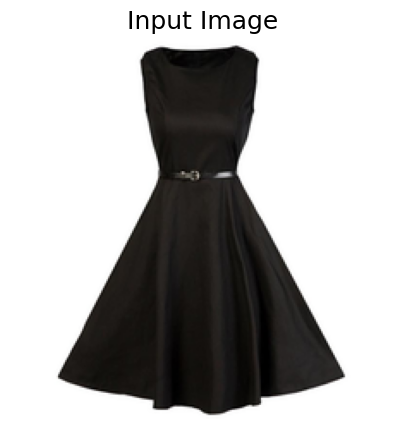

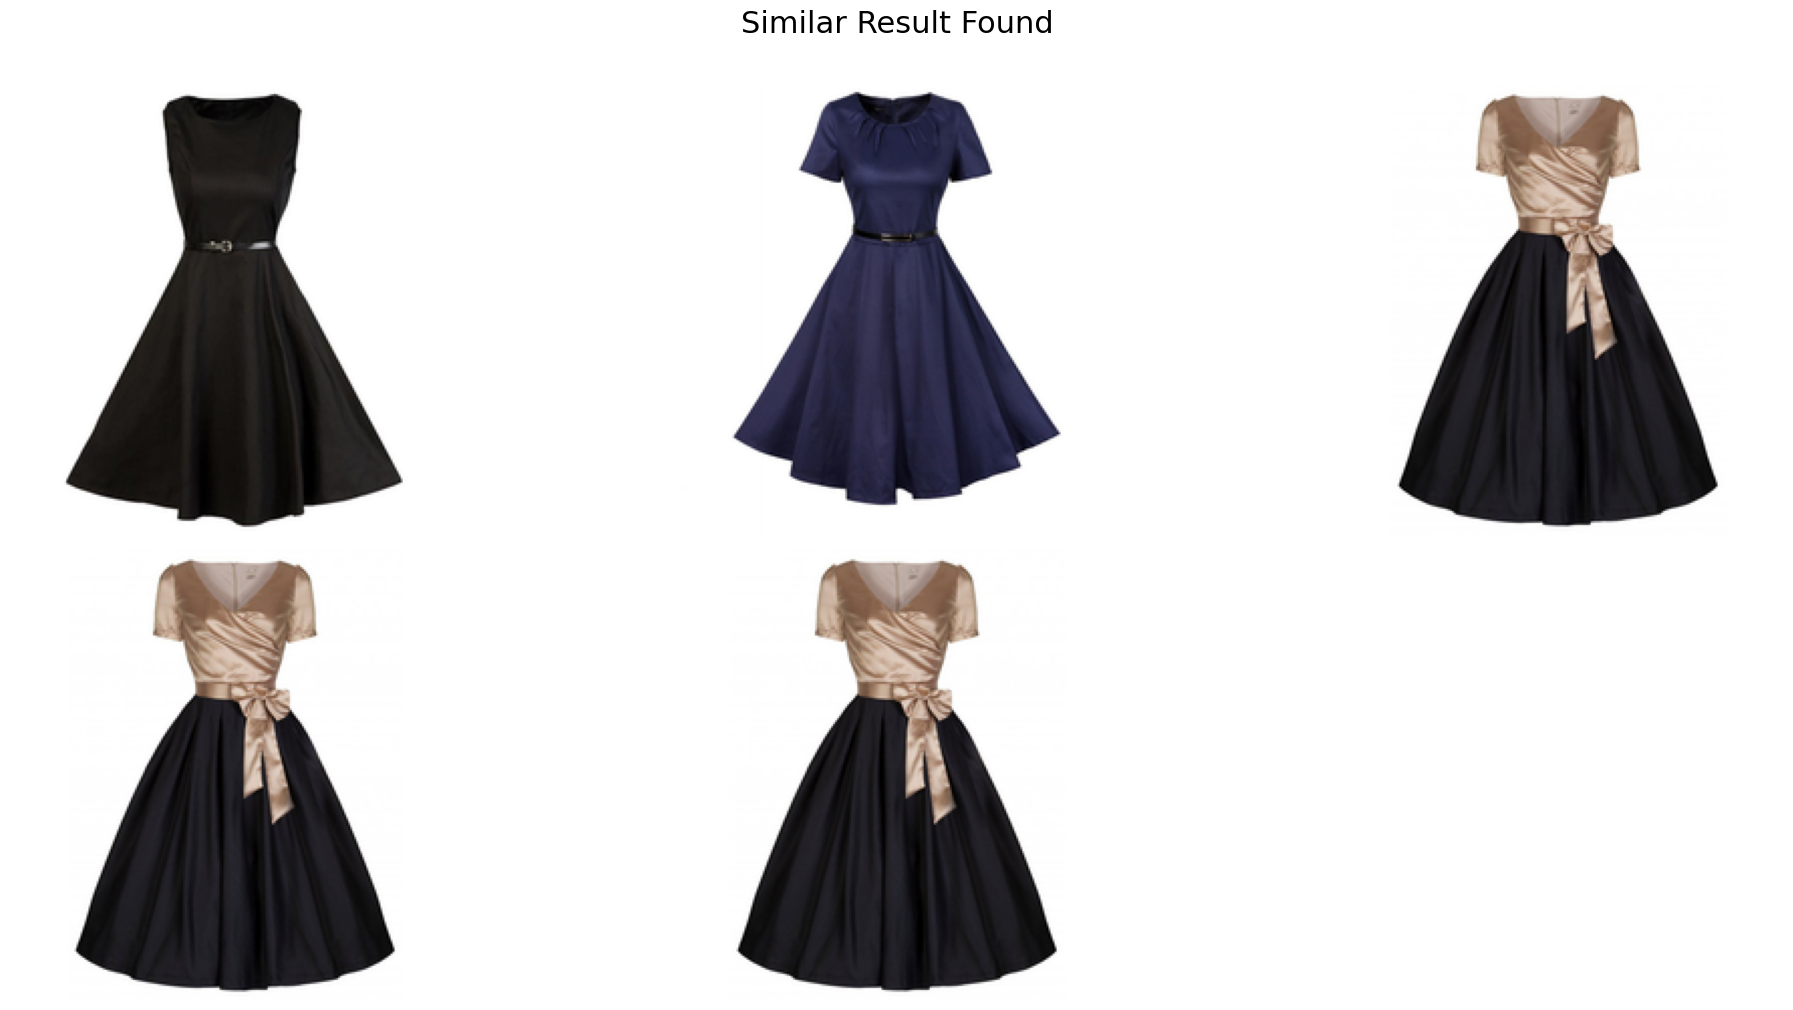

In [7]:
st.plot_similar_images(image_path = image_list[1],number_of_images=5)

In [ ]:
st.get_similar_images(image_path=image_list[1],number_of_images=5) 